https://www.kaggle.com/zephyrwang666/riiid-lgbm-bagging2-1

In [1]:
# Decide whether or not running on Kaggle
import os
KAGGLE_RUN = True
if os.path.isdir('/home/ubuntu'):
    KAGGLE_RUN = False
    
if KAGGLE_RUN:
    model_name = 'riiid-test-model/test_model3.txt'
else:
    model_name = 'test_model3.txt'
    
# Libraries
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import lightgbm as lgb
import random
if not KAGGLE_RUN:
    import sys
    sys.path.insert(0, './input')
    import local_work
import riiideducation

# Boto3 Setup and Download Files
if not KAGGLE_RUN:
    local_work = local_work.local_work()
    local_work.download_riiid_files()

# Set seed
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
    
# Define data for train.csv
data_types_dict = {
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

# Load data
if not KAGGLE_RUN:
    df_train = local_work.get_train_data(data_types_dict)
    #df_train = local_work.get_train_data(data_types_dict, nrow=10000000)
    df_questions = local_work.get_questions_data()
else:
    import datatable as dt
    df_train = dt.fread('../input/riiid-test-answer-prediction/train.csv'
                        ,columns=set(data_types_dict.keys())).to_pandas()
    df_questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv'
                                ,usecols=[0, 3]
                                ,dtype={'question_id': 'int16', 'part': 'int8'}
                               )

In [2]:
# Get rid of lecture rows
df_train = df_train[df_train[target] != -1].reset_index(drop=True)

# NA For a users first question bundle or lecture
df_train['prior_question_had_explanation'].fillna(False, inplace=True)

# Make data types
df_train = df_train.astype(data_types_dict)

In [3]:
# Running average of accuracy on users answer correctness
df_train['prev_correct'] = df_train.groupby('user_id')[target].shift()
cum = df_train.groupby('user_id')['prev_correct'].agg(['cumsum', 'cumcount'])
df_train['user_correctness'] = cum['cumsum'] / cum['cumcount']
df_train.drop(columns=['prev_correct'], inplace=True)

In [4]:
# User/Content aggregates of number of questions and how many where answered correctly
user_agg = df_train.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = df_train.groupby('content_id')[target].agg(['sum', 'count'])

# Keep only the 24 most recent rows for each user
df_train = df_train.groupby('user_id').tail(24).reset_index(drop=True)

In [5]:
# Merge questions frame to train
df_train = pd.merge(df_train, df_questions, left_on='content_id', right_on='question_id', how='left')
df_train.drop(columns=['question_id'], inplace=True)

In [6]:
# Left join content count and average correctness to each row
df_train['content_count'] = df_train['content_id'].map(content_agg['count']).astype('int32')
df_train['content_avg_correctness'] = df_train['content_id'].map(content_agg['sum'] / content_agg['count'])

[LightGBM] [Info] Number of positive: 3602877, number of negative: 2933798
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 6536675, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551179 -> initscore=0.205435
[LightGBM] [Info] Start training from score 0.205435
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.751093	valid_1's auc: 0.733432
[100]	training's auc: 0.752706	valid_1's auc: 0.735453
[150]	training's auc: 0.753337	valid_1's auc: 0.736056
[200]	training's auc: 0.753669	valid_1's auc: 0.736295
[250]	training's auc: 0.753936	valid_1's auc: 0.736444
[300]	training's auc: 0.754161	valid_1's auc: 0.736561
[350]	training's auc: 0.754374	valid_1's auc: 

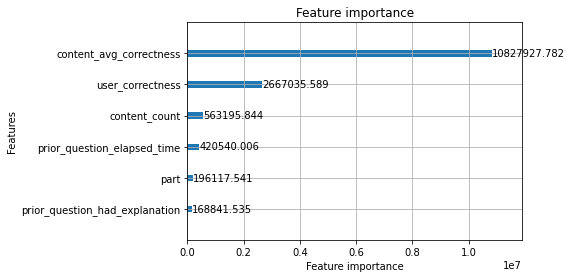

In [7]:
# Define validation set as the 6 most recent interactions
df_valid = df_train.groupby('user_id').tail(6)
df_train.drop(df_valid.index, inplace=True)

features = [
    'content_avg_correctness',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count'
]

if not KAGGLE_RUN:
    model = local_work.make_model(df_train, df_valid, target, features)
    model.save_model(f'./output/' + model_name)
    lgb.plot_importance(model, importance_type='gain')
else:
    model = lgb.Booster(model_file='/kaggle/input/' + model_name)

In [8]:
# Setup dicts
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

# Make env
env = riiideducation.make_env()
iter_test = env.iter_test()
df_prior_test = None

In [9]:
# Make predictions
for (df_test, df_sample_prediction) in iter_test:
    if df_prior_test is not None:
        df_prior_test[target] = eval(df_test['prior_group_answers_correct'].iloc[0])
        df_prior_test = df_prior_test[df_prior_test[target] != -1].reset_index(drop=True)

        user_ids = df_prior_test['user_id'].values
        content_ids = df_prior_test['content_id'].values
        targets = df_prior_test[target].values

        for user_id, content_id, answered_correctly in zip(user_ids, content_ids, targets):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1

    df_prior_test = df_test.copy()

    # Only keep questions posed to user
    df_test = df_test[df_test['content_type_id'] == 0].reset_index(drop=True)
    
    # Merge questions
    df_test = pd.merge(df_test, df_questions, left_on='content_id', right_on='question_id', how='left')
    
    # Fill NA and make boolean
    df_test['prior_question_had_explanation'] = df_test['prior_question_had_explanation']\
                                                    .fillna(False).astype('bool')    

    # Initialize
    user_sum = np.zeros(len(df_test), dtype=np.int16)
    user_count = np.zeros(len(df_test), dtype=np.int16)
    content_sum = np.zeros(len(df_test), dtype=np.int32)
    content_count = np.zeros(len(df_test), dtype=np.int32)

    for i, (user_id, content_id) in enumerate(zip(df_test['user_id'].values, df_test['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]

    df_test['user_correctness'] = user_sum / user_count
    df_test['content_count'] = content_count
    df_test['content_avg_correctness'] = content_sum / content_count

    df_test[target] = model.predict(df_test[features])
    env.predict(df_test[['row_id', target]])
print("Finished")

Finished


/home/ubuntu/kaggle_riiid/venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
